# 🧪 Lab 1 (Improved): From Location to Analysis (GeoPandas, STAC, & NDVI)
Objective: Learn to use geopandas to define a precise Area of Interest (AOI). Use this AOI to search the Planetary Computer's STAC catalog. Finally, load the raw satellite data bands to perform a scientific analysis (NDVI) and visualize the result.

## Key Concepts:

**geopandas:** A library for working with geospatial data in Python. It combines the power of pandas (for data tables) with shapely (for geometric operations).

**GeoDataFrame:** The fundamental data structure in geopandas. It's a table (like a spreadsheet) where one column (the 'geometry' column) holds geographic shapes.

**STAC** (SpatioTemporal Asset Catalog): The "search engine" for finding data.

**Cloud-Optimized GeoTIFF (COG):** The data format that lets us stream just the pixels we need.

**xarray & stackstac:** Libraries for loading and handling multi-dimensional data (like stacks of satellite bands) efficiently from the cloud.

**NDVI (Normalized Difference Vegetation Index):** A simple but powerful calculation used to measure and monitor plant health. It uses the Red and Near-Infrared (NIR) light bands.

NDVI = (NIR - Red) / (NIR + Red)

High values (near +1) mean healthy vegetation.

Low values (near 0 or negative) mean water, rock, or urban areas.

## Start the lab by running these commands in the terminal
Step 1: Open new terminal and install the environment.yaml file using 
   ``` conda env create -f azureml_environment.yml ```

Step 2: Activate the environment using ``` conda activate geo-labs-Lab1 ```

Step 3: Install ipykernel to interact with Jupyter notebook ``` conda install ipykernel --yes ```

Step 4: Run ```python -m ipykernel install --user --name geo-labs-azureml --display-name "Python (lab1))"```

***What to do next***
Refresh your browser tab where Jupyter Lab is running.

Open your notebook.

Click on the kernel name in the top-right corner.

You should now see "Python (geo-labs-azureml)" in the list. Select it

### 1. Import necessary libraries

We begin by importing all the Python packages we'll need.
* `pystac_client` & `planetary_computer`: Our tools for searching and authenticating with the Microsoft Planetary Computer's data catalog.
* `geopandas` & `shapely`: The standard for working with geographic vector data (like our AOI polygon).
* `stackstac`: A powerful library that loads STAC assets into an `xarray` data cube, handling mosaicking and reprojection for us.
* `rioxarray`: An extension for `xarray` that makes it "geospatial-aware."
* `folium`: Used to create an interactive "quick look" map.
* `matplotlib` & `contextily`: Used to create our final, static *analysis* plot with a basemap.

In [1]:
%pip install leafmap ipywidgets localtileserver ipyleaflet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pystac_client
import planetary_computer
import geopandas as gpd
from shapely.geometry import box
import stackstac
import rioxarray # needed for xarray to work with geotiffs
import folium
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


### 2. Connect to the Planetary Computer STAC Catalog

Here, we create our `catalog` object. This is our main connection to the STAC (SpatioTemporal Asset Catalog) API. Think of it as the "search engine" for the petabytes of data on the Planetary Computer.

The `modifier=planetary_computer.sign_inplace` part is crucial. It tells our client to automatically add authentication credentials to any data links we find, allowing us to access the data without any complex setup.

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
print("Connected to MPC STAC catalog.")

Connected to MPC STAC catalog.


### 3. 📍 Define an Area of Interest (AOI) with GeoPandas
We must first define an **Area of Interest (AOI)** due to compute limitations as a larger map will require more compute power. We're using `geopandas` to create a `GeoDataFrame` containing a single `box` polygon.

⛰️ What Are We Looking At?
* Our Area of Interest (AOI) is centered on **Mount Rainier, Washington**.

It's an active stratovolcano and the most heavily glaciated peak in the contiguous United States. We chose this location because it's a perfect "natural laboratory" for NDVI analysis.

Instead of a uniform area (like a single farm field), our AOI contains extreme variations in land cover, all in one small patch:

Base: Dense, old-growth evergreen forests (High Vegetation).

Slopes: Subalpine meadows (Medium Vegetation).

Summit: Permanent snowfields, massive glaciers, and bare volcanic rock (No Vegetation).

Because of this, we should see a fascinating result:

High NDVI (Green) in the forests.

Medium NDVI (Yellow) in the meadows.

Very Low/Negative NDVI (Red/Orange) on the ice and rock at the peak.

* We set the Coordinate Reference System (CRS) to `EPSG:4326`, which is the standard code for global latitude and longitude.

In [4]:
min_lon, min_lat, max_lon, max_lat = [-121.9, 46.7, -121.5, 46.9]

# Create a shapely geometry object
min_lon, min_lat, max_lon, max_lat = [-121.9, 46.7, -121.5, 46.9]
aoi_geometry = box(min_lon, min_lat, max_lon, max_lat)
aoi_gdf = gpd.GeoDataFrame(
    {"name": ["Mount Rainier AOI"]},
    geometry=[aoi_geometry],
    crs="EPSG:4326"
)

print("✓ GeoDataFrame created:")
print(aoi_gdf.head())

✓ GeoDataFrame created:
                name                                           geometry
0  Mount Rainier AOI  POLYGON ((-121.5 46.7, -121.5 46.9, -121.9 46....


### 4. 🛰️ Search the Catalog

Now we use our `catalog` to search for data that matches our criteria. We are building a specific query:
* `collections`: We want `sentinel-2-l2a`, which is high-resolution (10m) satellite imagery.
* `intersects`: We only want images that *touch* our `aoi_gdf` geometry.
* `datetime`: We specify a time range.
* `query`: We filter for images with less than 15% cloud cover.
* `sortby`: This is key! We sort the results so the **least cloudy** image appears first.

In [5]:
time_of_interest = "2023-06-01/2023-09-30" # Widen the search window to all of summer

print(f"Searching for images intersecting {aoi_gdf.total_bounds}...")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=aoi_gdf.geometry[0],
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 15}}, # Loosen cloud cover slightly to get more results
    sortby=[ # Sort the results to get the best one
        {"field": "eo:cloud_cover", "direction": "asc"},
    ]
)

items = search.item_collection()
print(f"✓ Found {len(items)} matching images.")

Searching for images intersecting [-121.9   46.7 -121.5   46.9]...
✓ Found 156 matching images.


### 5. Select the first (least cloudy) item

The search returns a list of all matching items. Since we sorted by cloud cover, the first item in the list (`items[0]`) is the *best* single image for a quick preview. We'll select this item to display on our interactive map.

In [6]:
if len(items) == 0:
    raise Exception("No items found. Try expanding your time range or AOI.")

first_item = items[0]
print(f"✓ Selected item: {first_item.id}")
print(f"   - Captured on: {first_item.datetime.date()}")
print(f"   - Cloud cover: {first_item.properties['eo:cloud_cover']}%")

✓ Selected item: S2B_MSIL2A_20230914T190019_R013_T10TFT_20241024T011208
   - Captured on: 2023-09-14
   - Cloud cover: 0.000395%


### 6. 🗺️ Create a quick-view map with Folium
This step is a **"quick look" preview**, not our final analysis. We use `folium` to create an interactive map.

We take the `visual` asset (a pre-made RGB image) from our `first_item` and get its URL. We pass this URL to the Planetary Computer's `titiler` service, which dynamically creates map tiles that `folium` can understand and display. This lets us confirm our AOI is in the right place and that the image is clear.

In [7]:
print("Generating interactive 'True Color' map...")

# Get the signed URL for the 'visual' (RGB) asset
cog_url = first_item.assets["visual"].href

# Create a Titiler URL. This service will generate tiles for Folium.
titiler_endpoint = "https://titiler.planetarycomputer.microsoft.com"
tile_url = f"{titiler_endpoint}/cog/tiles/{{z}}/{{x}}/{{y}}?url={cog_url}"

bounds = aoi_gdf.total_bounds  # Gets [min_lon, min_lat, max_lon, max_lat]
center_lon = (bounds[0] + bounds[2]) / 2
center_lat = (bounds[1] + bounds[3]) / 2

# Create the map
m_visual = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles="CartoDB positron")

# Add the COG tiles as a layer
folium.TileLayer(
    tiles=tile_url,
    attr="Microsoft Planetary Computer / Titiler",
    name="True Color (RGB)",
    overlay=True
).add_to(m_visual)

# Add our AOI as a red outline
folium.GeoJson(
    aoi_gdf,
    style_function=lambda x: {"fill": False, "color": "red", "weight": 2},
    name="Our AOI"
).add_to(m_visual)

folium.LayerControl().add_to(m_visual)

print("✓ Map created. Displaying map...")
display(m_visual)

Generating interactive 'True Color' map...
✓ Map created. Displaying map...


## Part 2: Data Loading & Analysis (The "Science")
Now, we'll load the actual data bands we need for our NDVI calculation: Red (Band 4) and Near-Infrared (Band 8).

### 7. 💡 Load raw data bands using stackstac
This is the most important data-loading step. We are no longer using just the `first_item` or the simple `visual` asset.

Instead, we pass the **entire `items` collection** to `stackstac`. It will:
1.  Find *all* the tiles that intersect our AOI.
2.  Load only the specific bands we need for analysis: **`B04` (Red)** and **`B08` (NIR)**.
3.  **Mosaic** (stitch) all the separate tiles together into one seamless image.
4.  Re-project the data to `EPSG:3857` (a CRS in meters) so our `resolution=10` (meters) makes sense.
5.  Return a single, clean `xarray.DataArray` (a data cube) ready for analysis.

In [8]:
print("Loading raw data bands (B04-Red, B08-NIR) for analysis...")
print(f"   - Mosaicking {len(items)} items to cover the full AOI.")

data = stackstac.stack(
    items,                               # Pass the entire 'items' collection
    assets=["B04", "B08"],               # List of bands to load
    bounds_latlon=aoi_gdf.total_bounds,  # Use our original lat/lon bounds
    resolution=20,                       # Sentinel-2 resolution is 10m
    epsg=3857                            # Set output CRS to Web Mercator (meters)
    # This will now mosaic all items that cover our AOI
)

print("✓ Data loaded and mosaicked (time dimension preserved):")
print(data)

Loading raw data bands (B04-Red, B08-NIR) for analysis...
   - Mosaicking 156 items to cover the full AOI.
✓ Data loaded and mosaicked (time dimension preserved):
<xarray.DataArray 'stackstac-d331b1e87e3d586c1325f08626f376c8' (time: 156,
                                                                band: 2,
                                                                y: 1627, x: 2228)> Size: 9GB
dask.array<fetch_raster_window, shape=(156, 2, 1627, 2228), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 1kB 2023-0...
    id                                       (time) <U54 34kB 'S2A_MSIL2A_202...
  * band                                     (band) <U3 24B 'B04' 'B08'
  * x                                        (x) float64 18kB -1.357e+07 ... ...
  * y                                        (y) float64 13kB 5.926e+06 ... 5...
    s2:water_percentage                      (tim

### 8. 📈 Perform Analysis (Calculate NDVI)

This is the core scientific analysis of our lab. We will calculate the **Normalized Difference Vegetation Index (NDVI)**, a powerful measurement of vegetation health.

The formula is **`NDVI = (NIR - Red) / (NIR + Red)`** which is a powerful indicator of plant health. By subtracting and dividing the arrays, we create a new layer where each pixel's value tells us about the vegetation.

Healthy vegetation actively absorbs **Red** light (Band 4) for photosynthesis and strongly reflects **Near-Infrared (NIR)** light (Band 8). Bare soil, rock, and snow do the opposite. By calculating this ratio for every pixel, we create a new data layer where:
* **High values (near +1.0)** = Healthy, dense vegetation.
* **Low values (near 0)** = Bare soil or rock.
* **Negative values (< 0)** = Water, snow, or ice.

**Note:** When we perform math on `xarray` objects, they sometimes "lose" their metadata. We must add the `.rio.write_crs()` line to re-assign the Coordinate Reference System (CRS) to our new `ndvi` object. This is essential for our map-plotting step.

In [9]:
# Squeeze() removes the 'time' dimension (since we only have 1)
print("Calculating NDVI...")
# Create a single, cloud-free image by taking the median
# across the 'time' dimension. This combines all tiles
# even if they are from different dates.
median_composite = data.median(dim="time")
# Now, calculate NDVI from the composite image
red_band = median_composite.sel(band="B04")
nir_band = median_composite.sel(band="B08")

# NDVI = (NIR - Red) / (NIR + Red)
ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-6)
ndvi.name = "NDVI"

# Re-assign the CRS, which gets lost during arithmetic
ndvi.rio.write_crs("EPSG:3857", inplace=True)

print("✓ Median composite created and NDVI calculation complete.")

Calculating NDVI...
✓ Median composite created and NDVI calculation complete.


## Part 3: Visualize the Analysis
---------------------------------
Finally, let's map our analysis result

This is our final **analysis plot**. Unlike the `folium` "quick look," this map shows our *calculated NDVI data*.

We use `matplotlib` to plot the `ndvi` array, applying a "Red-Yellow-Green" (`RdYlGn`) colormap where:
* **Green (High NDVI):** Healthy forests.
* **Yellow (Low NDVI):** Sparse vegetation or rock.
* **Red/Orange (Negative NDVI):** Snow and ice.

We use `contextily` to add a basemap underneath for context. The axes are in **Easting (X)** and **Northing (Y)** because our data is in `EPSG:3Stream (meters)`.

In [10]:
print("NDVI DataArray dimensions:", ndvi.dims)
print("NDVI DataArray coordinates:", ndvi.coords)

NDVI DataArray dimensions: ('y', 'x')
NDVI DataArray coordinates: Coordinates:
  * x                                        (x) float64 18kB -1.357e+07 ... ...
  * y                                        (y) float64 13kB 5.926e+06 ... 5...
    instruments                              <U3 12B 'msi'
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    s2:product_type                          <U7 28B 'S2MSI2A'
    proj:code                                <U10 40B 'EPSG:32610'
    constellation                            <U10 40B 'Sentinel 2'
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    proj:shape                               object 8B {10980}
    gsd                                      float64 8B 10.0
    epsg                                     int64 8B 3857
    spatial_ref                              int64 8B 0


Generating static analysis map with Matplotlib...
✓ Basemap added.


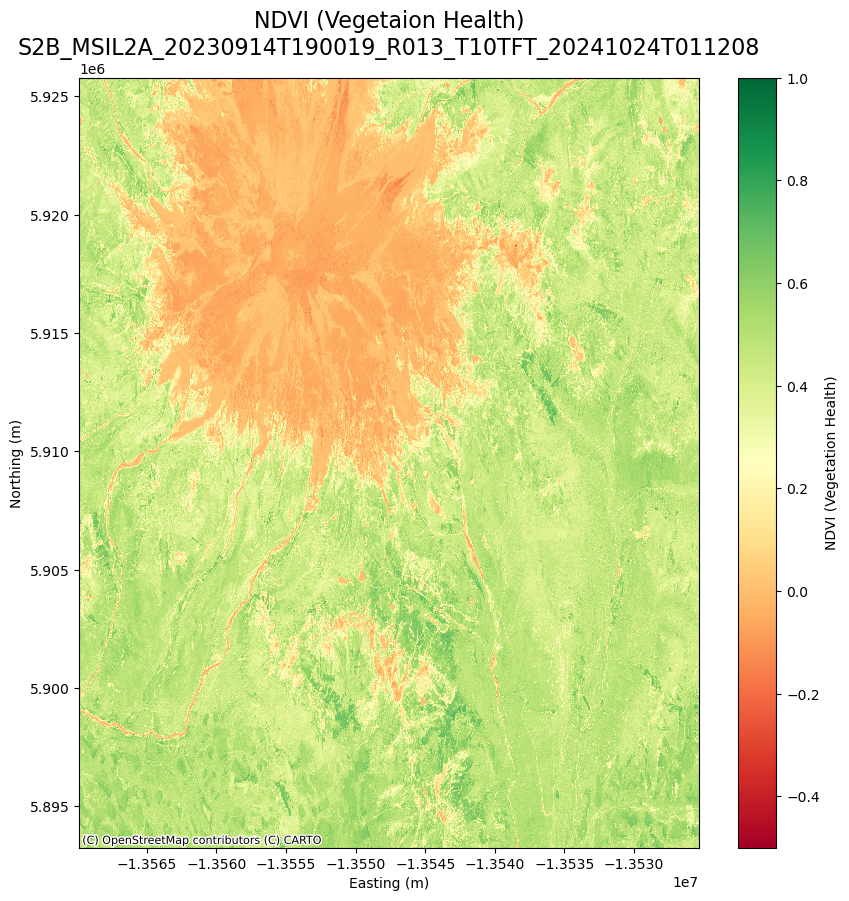

In [11]:
print("Generating static analysis map with Matplotlib...")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the NDVI data
# We specify the color map (cmap) and add a color bar
ndvi.plot(
    ax=ax,
    cmap="RdYlGn",  # Red-Yellow-Green colormap, good for NDVI
    add_colorbar=True,
    cbar_kwargs={'label': 'NDVI (Vegetation Health)'},
    vmin=-0.5, vmax=1  # Set common NDVI min/max
)

# Use contextily to add a basemap
# We must specify the CRS of our data so the basemap aligns correctly
try:
    ctx.add_basemap(
        ax,
        crs=ndvi.rio.crs.to_string(),
        source=ctx.providers.CartoDB.Positron,
        alpha=0.75
    )
    print("✓ Basemap added.")
except Exception as e:
    print(f"   - Warning: Could not add basemap. Displaying data only. Error: {e}")

ax.set_title(f"NDVI (Vegetaion Health)\n{first_item.id}", fontsize=16)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

plt.show()

## Explanation: Look at the map! You should see a clear difference between different land covers.

**Deep Green:** Dense forests on the mountain slopes (high NDVI).

**Yellow/Tan:** Sparse vegetation, bare ground (low NDVI).

**Red/Brown:** The snow and glaciers at the peak (negative NDVI, as snow reflects more Red than NIR).

# 10. 🔬 Analyze NDVI Results
A map is great, but numbers give us a more precise summary. Here, we calculate the basic descriptive statistics for our AOI. This tells us the **mean**, **median**, **min**, and **max** NDVI values, giving us a quantitative snapshot of the area's overall vegetation health.

In [12]:
%pip install dask

Note: you may need to restart the kernel to use updated packages.


In [13]:
from dask.diagnostics import ProgressBar
import dask

print("Calculating statistics for NDVI data...")

# We are now using xarray's Dask-aware methods (.mean(), .median(), etc.)
# This calculates the stats *in chunks* without loading the
# entire array into memory, which is far more efficient.
# The .compute() at the end just computes the final single number.
#
# We also add .fillna(np.nan) for the median, as xarray's median
# doesn't have a built-in nan-skip for dask arrays.
# 1. Define lazy calculations
mean_ndvi = ndvi.mean(skipna=True)
min_ndvi = ndvi.min(skipna=True)
max_ndvi = ndvi.max(skipna=True)
std_dev_ndvi = ndvi.std(skipna=True)

# 2. Compute them all at once with a progress bar
print("   - Computing stats (watch progress bar below)...")
with ProgressBar():
    (
        mean_val,
        min_val,
        max_val,
        std_val
    ) = dask.compute(
        mean_ndvi,
        min_ndvi,
        max_ndvi,
        std_dev_ndvi
    )

print("✓ Statistics calculation complete.")

# 3. Print the final (now computed) values
print("\n--- NDVI Statistics ---")
print(f"Mean NDVI:    {mean_val.item():.4f}")
print(f"Min NDVI:     {min_val.item():.4f}")
print(f"Max NDVI:     {max_val.item():.4f}")
print(f"Std. Dev.:    {std_val.item():.4f}")

Calculating statistics for NDVI data...
   - Computing stats (watch progress bar below)...
[########################################] | 100% Completed | 80.64 s
✓ Statistics calculation complete.

--- NDVI Statistics ---
Mean NDVI:    0.3360
Min NDVI:     -0.3321
Max NDVI:     0.7614
Std. Dev.:    0.2079


# 11. Histogram of NDVI Distribution
This histogram is a powerful way to see the *types* of land cover in our image. We'd expect to see a "bimodal" distribution (two main peaks):
1.  A peak at the **negative end**, representing all the snow and ice on the volcano's summit.
2.  A peak at the **high positive end**, representing all the dense forests on its slopes.

The values in between are the meadows and bare rock.


Generating NDVI histogram...
   - Coarsening data for efficient histogram ...
   - Loading coarse data into memory...
[########################################] | 100% Completed | 63.82 s
✓ Coarse data loaded. Plotting histogram...


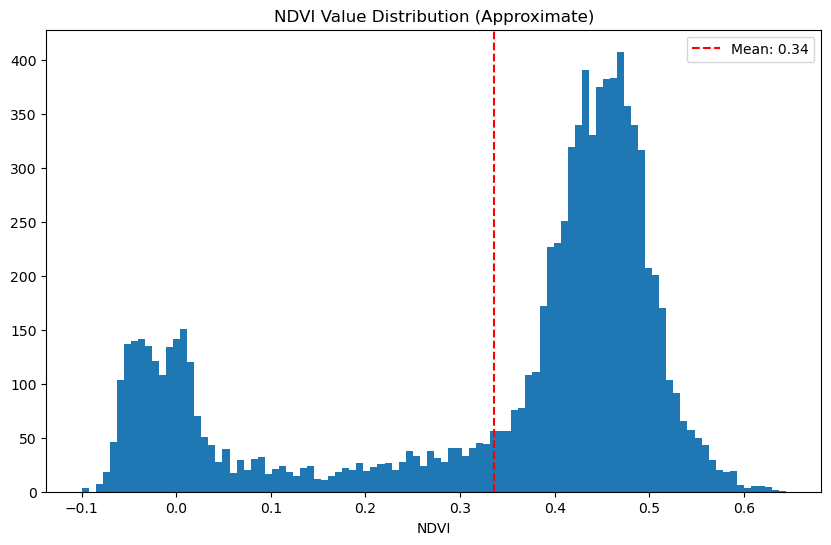

In [15]:
print("\nGenerating NDVI histogram...")
print("   - Coarsening data for efficient histogram ...")

# We "coarsen" the data by making 20x20 pixel blocks and
# taking the mean. This reduces data 400x.
# This is a standard way to get a representative histogram.
coarse_ndvi = ndvi.coarsen(x=20, y=20, boundary="pad").mean()

# Now, load only this small, coarse array into memory
print("   - Loading coarse data into memory...")
with ProgressBar():
    coarse_ndvi_loaded = coarse_ndvi.load()

print("✓ Coarse data loaded. Plotting histogram...")

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram of the *coarse* (approximate) data
coarse_ndvi_loaded.plot.hist(ax=ax, bins=100)

ax.set_title("NDVI Value Distribution (Approximate)")
ax.set_xlabel("NDVI")

# We use the *accurate* mean (mean_val) from Step 10
ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')

ax.legend()
plt.show()

💡 Interpretation Guide
NDVI > 0.6 (High Green on Map): Indicates dense, healthy vegetation, like the forests on the mountain slopes.

0.2 < NDVI < 0.5 (Yellow/Tan on Map): Represents sparse vegetation, grasslands, or bare soil.

NDVI < 0.1 (Red on Map): These are non-vegetated surfaces.

Near 0: Rock, bare soil, or urban areas.

< 0 (Negative): Water, and in this case, the snow and glaciers on top of Mount Rainier. This is because snow reflects more Red light than Near-Infrared light, resulting in a negative value.

# 12. 💾 (Optional) Export your result to a GeoTIFF

Finally, we save our work. We use `.rio.to_raster()` to export our `ndvi` data array to a file named `ndvi_mount_rainier.tif`.

This creates a **Cloud-Optimized GeoTIFF (COG)**, which is the standard, high-performance format for geospatial raster data. You can now download this file and open it in other GIS software like QGIS or ArcGIS.

In [16]:
output_filename = "ndvi_mount_rainier.tif"
print(f"\nExporting analysis result to {output_filename}...")

try:
    ndvi.rio.to_raster(output_filename, crs=ndvi.rio.crs, driver="COG")
    print(f"✓ Successfully exported analysis to {output_filename}")
    print("   - You can find this file in the Jupyter file browser.")
except Exception as e:
    print(f"   - Error exporting file: {e}")


Exporting analysis result to ndvi_mount_rainier.tif...
✓ Successfully exported analysis to ndvi_mount_rainier.tif
   - You can find this file in the Jupyter file browser.


# 🚀 Exploration (For Students)
Compare Maps: Look at the interactive folium map (Part 1) and the static matplotlib map (Part 3). How do the "True Color" features match the NDVI analysis?

Analyze the Histogram: What does the histogram (Part 4) tell you? You should see a "bimodal" distribution—one peak for the negative values (snow/ice) and another for the positive values (forests).

Change AOI: Define a new aoi_gdf over an agricultural area (e.g., in Eastern Washington) or a city (e.g., Seattle). Rerun the notebook and see how the statistics and histogram change.

Try a Different Index: Calculate the Normalized Difference Water Index (NDWI), which highlights water. The formula is (Green - NIR) / (Green + NIR). You'll need to load the Green band ('B03') in step 7 and use the colormap cmap="Blues".